# SST Individual Discriminability

This notebook measures discriminability of conditions for each subject, within runs.

It then takes the average discriminability across any multiple runs (I don't think we have them though).

Then we can compare discriminability against other subject-level variables.



Something similar was previously been done in `rsa_within_subj.ipynb`; it took similarity between matrices representing the averages of GNG and compared them intra-class similarity.

That file doesn't take the next step of trying to see how that similarity score might measure up against across-subject variables; it seems, because I did not find good evidence that intrasimilarity was actually higher than interclass similarity.

Conclusions:

 - maybe I should have tried discriminability, not just similarity
 - If we're interested in discriminability, then running an ML algorithm should be superior?
 - But don't rule out going back to similarity.

### General set-up

## TESQ

### TESQ Machine learning set-up

Some of the below can probably be moved to "general set-up" as appropriate.

In [1]:
from discriminability_tools import *

python initialized for apply_loocv_and_save


/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


28 25
28


In [2]:
import pickle
from IPython.core.display import display, HTML, Markdown
from nilearn.decoding import Decoder
from sklearn.model_selection import StratifiedKFold
from random import randint
import math

In [3]:
import sys
import os
import pandas as pd
import gc

sys.path.append(os.path.abspath("../../ml/"))

from apply_loocv_and_save import *
from dev_wtp_io_utils import *
import gc
import nibabel as nib

from os import path



nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"
train_test_markers_filepath = ml_data_folderpath + "/train_test_markers_20210601T183243.csv"
test_train_df = pd.read_csv(train_test_markers_filepath)

all_sst_events= pd.read_csv(ml_data_folderpath +"/SST/" + "all_sst_events.csv")


dataset_name = 'conditions'

from nilearn.decoding import DecoderRegressor, Decoder

script_path = '/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml'
# HRF 2s

#get a PFC mask
#pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)


def trialtype_resp_trans_func(X):
    return(X.trial_type)



In [4]:

cpus_available = int(os.getenv('CPUS_PER_TASK'))
#custom thing I have set in my jupyter notebook task.
print(cpus_available)
cpus_to_use = cpus_available-1

4


### TESQ Analysis set-up

In [5]:
from analyze_results import remove_selected_outliers
from scipy.stats import pearsonr,spearmanr
from matplotlib import pyplot

def remove_selected_outliers_tesq_study(ind_div_combined,show_plot=False):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['discriminability_overfit_accuracy','discriminability_mean_cv_scores',
        'BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy',
     'cancer_promoting_minus_preventing_FFQ','bf_1'],
    show_plot=show_plot)
    return(idc_outliers_removed)

def display_discriminability_correlations(ind_div_combined_3sd):
    for neural_var in ['discriminability_overfit_accuracy','discriminability_mean_cv_scores']:
        display(Markdown("### " + neural_var))
        for correlate in ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
                          'SST_SSRT','BIS_11','BSCS',
                          'TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
                          'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
                          'TESQ_E_goal_and_rule_setting',
                        'EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look','SRHI_unhealthy']:
            display(Markdown("#### " + correlate))
            nan_rows = np.isnan(ind_div_combined_3sd[correlate]) | np.isnan(ind_div_combined_3sd[neural_var])
            cor2way_df = ind_div_combined_3sd.loc[nan_rows==False,]
            pearson_result = pearsonr(cor2way_df[neural_var],cor2way_df[correlate])
            display(HTML("r=" + format(pearson_result[0],".2f") +"; p-value=" + format(pearson_result[1],".4f")))
            spearman_result = spearmanr(cor2way_df[neural_var],cor2way_df[correlate])
            display(HTML("rho=" + format(spearman_result[0],".2f") +"; p-value=" + format(spearman_result[1],".4f")))
            cplot = pyplot.scatter(cor2way_df[neural_var],cor2way_df[correlate])
            cplot.axes.set_xlabel(neural_var)
            cplot.axes.ylabel=correlate
            pyplot.show()

### Machine learning

First set up.

In [6]:
cpus_to_use

3

 `load_and_preprocess` has problems but I"m going to continue using it because I'm having problems with the standardization in the nilearn package. So there's not much point in deviating. We can also use the slicer in load_and_preprocess, if we get teh subject list first.
 
To get the subject list, we'll load the data once, get the list, and then load each subject individually.

This takes too long. For that reason, even though there are accuracy challenges, I'd like to proceed with a short-cut--we do 10-fold cross validation using the LeaveOneGroupOut feature, and ensure that Go and NoGo values are as evenly distributed across the groups as possible.

But we'll leave the capacity to do full LeaveOneOut in there because it's probably good to go back to in the future.

First to test the technical process, let's try doing just three manually-generated groups.

OK, so this isn't very good for actually closely understanding what is being classified as what; we're not getting predictions for the scores under the hood. But we can take a look at the overall predictive accuracy on a non-held-out set. Note that we can't use this for asssessing model fit (to do that we better take the average of the prediction accuracies for the folds, or run an independent test-train analysis) but we can use this to understand things like class bias or look at the image being predicted.

Not sure it actually matters to overfit here? We're interested in discriminability not to see if we really can discriminate above chance, but as an individual difference; to see if relative discriminability relates to other things we care about.

In that sense, we probably don't have to worry about overfitting.

How to deal with imbalanced classes?
We're using svc. One solution: https://chrisalbon.com/code/machine_learning/support_vector_machines/imbalanced_classes_in_svm/

### analysis

### Next steps

probably repeat the whole process with some masks excluding, at a minimum, movement and visual cortices. We also are using a 40-subject dataset. It needs to be extended to 84-subject, even though this is going to be difficult because the dataset is so much more detailed. We need to get good at only storing a minimal amount of data at a time.

In fact, extending to 84-subjects is probably the very first thing we need to handle.

### Repeating the above with 84 subjects

In [6]:
dataset_name = 'conditions'


brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_58subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None

In [7]:
all_subjects = load_and_preprocess(
    brain_data_filepath,
    train_test_markers_filepath,
    subjs_to_use = None,
    response_transform_func = trialtype_resp_trans_func,
    clean=None)

all_subjects['groups']

subj_list = np.unique(all_subjects['groups'])

del all_subjects
gc.collect()

checked for intersection and no intersection between the brain data and the subjects was found.
there were 58 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 16
subjs_to_use: 16


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


9037
9037


0

In [14]:
subj_list

array(['DEV005', 'DEV006', 'DEV009', 'DEV010', 'DEV011', 'DEV012',
       'DEV013', 'DEV014', 'DEV015', 'DEV016', 'DEV017', 'DEV018',
       'DEV019', 'DEV020', 'DEV021', 'DEV022', 'DEV023', 'DEV024',
       'DEV025', 'DEV026', 'DEV027', 'DEV028', 'DEV029', 'DEV030',
       'DEV034', 'DEV035', 'DEV036', 'DEV039', 'DEV040', 'DEV041',
       'DEV042', 'DEV043', 'DEV046', 'DEV047', 'DEV048', 'DEV049',
       'DEV050', 'DEV051', 'DEV052', 'DEV053', 'DEV055', 'DEV056',
       'DEV057', 'DEV058', 'DEV059', 'DEV060', 'DEV062', 'DEV064',
       'DEV067', 'DEV068', 'DEV069', 'DEV071', 'DEV073', 'DEV074',
       'DEV076', 'DEV077', 'DEV079', 'DEV083', 'DEV084', 'DEV085',
       'DEV086', 'DEV087', 'DEV089', 'DEV097', 'DEV105', 'DEV107',
       'DEV135', 'DEV141', 'DEV145', 'DEV157', 'DEV158', 'DEV159',
       'DEV164', 'DEV169', 'DEV171', 'DEV173', 'DEV177', 'DEV186',
       'DEV197', 'DEV206', 'DEV215', 'DEV216', 'DEV217', 'DEV218'],
      dtype=object)

In [17]:
summary_results = get_all_subjs_discriminability_whole_brain(subj_list,
                                                            ,
    subject_discrim_args = 
    {'train_test_markers_filepath':train_test_markers_filepath, 
     'brain_data_filepath':brain_data_filepath, 
     'resp_trans_func': trialtype_resp_trans_func,
     'mask':pfc_mask})

DEV005

pre-loaded.

DEV006

pre-loaded.

DEV009

pre-loaded.

DEV010

pre-loaded.

DEV011

pre-loaded.

DEV012

pre-loaded.

DEV013

pre-loaded.

DEV014

pre-loaded.

DEV015

pre-loaded.

DEV016

pre-loaded.

DEV017

pre-loaded.

DEV018

pre-loaded.

DEV019

pre-loaded.

DEV020

pre-loaded.

DEV021

pre-loaded.

DEV022

pre-loaded.

DEV023

pre-loaded.

DEV024

pre-loaded.

DEV025

pre-loaded.

DEV026

pre-loaded.

DEV027

pre-loaded.

DEV028

pre-loaded.

DEV029

pre-loaded.

DEV030

pre-loaded.

DEV034

pre-loaded.

DEV035

pre-loaded.

DEV036

pre-loaded.

DEV039

pre-loaded.

DEV040

pre-loaded.

DEV041

pre-loaded.

DEV042

pre-loaded.

DEV043

pre-loaded.

DEV046

pre-loaded.

DEV047

pre-loaded.

DEV048

pre-loaded.

DEV049

pre-loaded.

DEV050

pre-loaded.

DEV051

pre-loaded.

DEV052

pre-loaded.

DEV053

pre-loaded.

DEV055

pre-loaded.

DEV056

pre-loaded.

DEV057

pre-loaded.

DEV058

pre-loaded.

DEV059

pre-loaded.

DEV060

pre-loaded.

DEV062

pre-loaded.

DEV064

pre-loaded.

DEV067

pre-loaded.

DEV068

pre-loaded.

DEV069

pre-loaded.

DEV071

pre-loaded.

DEV073

pre-loaded.

DEV074

pre-loaded.

DEV076

pre-loaded.

DEV077

pre-loaded.

DEV079

pre-loaded.

DEV083

pre-loaded.

DEV084

pre-loaded.

DEV085

pre-loaded.

DEV086

pre-loaded.

DEV087

pre-loaded.

DEV089

pre-loaded.

DEV097

pre-loaded.

DEV105

pre-loaded.

DEV107

pre-loaded.

DEV135

pre-loaded.

DEV141

pre-loaded.

DEV145

pre-loaded.

DEV157

pre-loaded.

DEV158

pre-loaded.

DEV159

pre-loaded.

DEV164

pre-loaded.

DEV169

pre-loaded.

DEV171

pre-loaded.

DEV173

pre-loaded.

DEV177

pre-loaded.

DEV186

pre-loaded.

DEV197

pre-loaded.

DEV206

pre-loaded.

DEV215

pre-loaded.

DEV216

pre-loaded.

DEV217

pre-loaded.

DEV218

pre-loaded.

In [20]:
# correlate discriminability against shit we care about.

summary_results2 = summary_results.rename(columns={
    'mean_cv_scores':'discriminability_mean_cv_scores',
    'overfit_accuracy':'discriminability_overfit_accuracy'})


individual_differences = pd.read_csv(ml_data_folderpath + "/" + data_by_ppt_name)
individual_differences = individual_differences.rename(columns={'SID':'subid'})
individual_differences['wave']=1
#individual_differences['wave'] = individual_differences['wave'].astype(object) # for compatibility with the wave column in the dataset
ind_div_combined = summary_results2.merge(individual_differences)

#### discriminability_overfit_accuracy

0.6696428571428571 0.12951720486153828 0.5401256522813188 0.7991600620043954


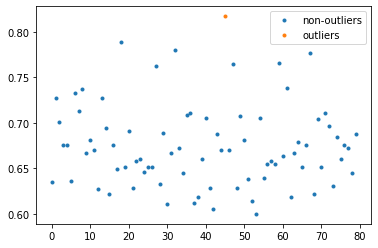

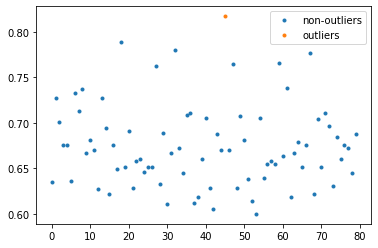

0.6696428571428571 0.12951720486153828 0.5401256522813188 0.7991600620043954


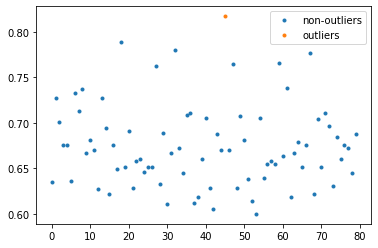

80 , 79
0.6696428571428571 0.12057894943778787 0.5490639077050692 0.790221806580645


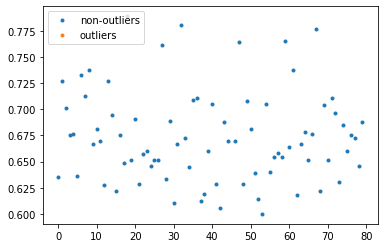

79 , 79


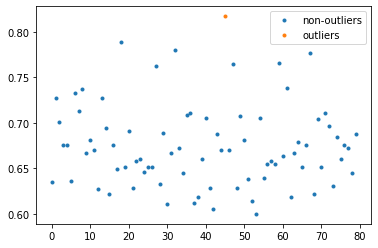

80 , 79


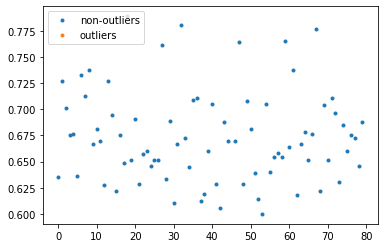

79 , 79


#### discriminability_mean_cv_scores

0.37868498750851687 0.1311143649823419 0.24757062252617495 0.5097993524908588


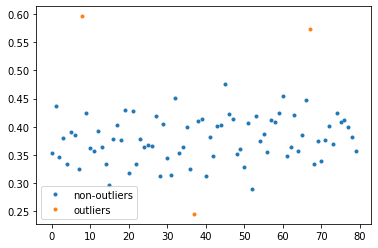

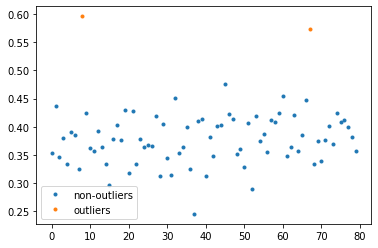

0.37868498750851687 0.1311143649823419 0.24757062252617495 0.5097993524908588


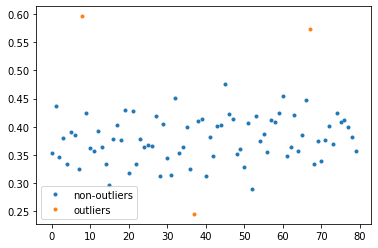

80 , 77
0.37837837837837834 0.12405975737539389 0.25431862100298447 0.5024381357537723


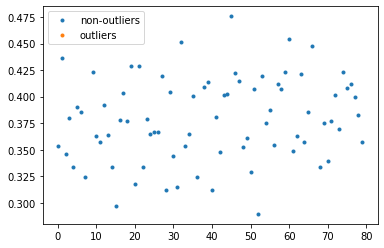

77 , 77


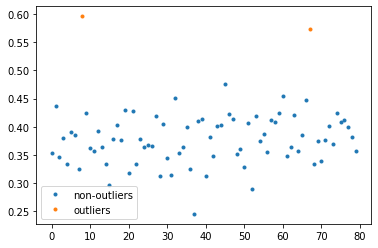

80 , 78


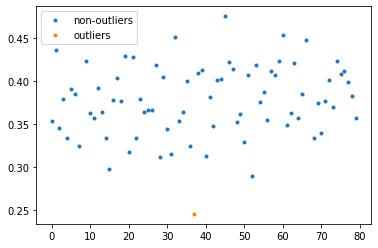

78 , 77


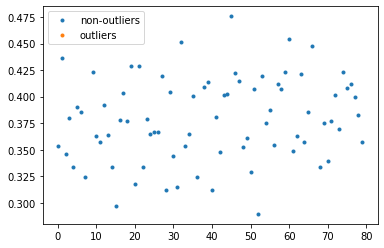

77 , 77


#### BFI_extraversion

26.0 20.266128342428956 5.733871657571044 46.266128342428956


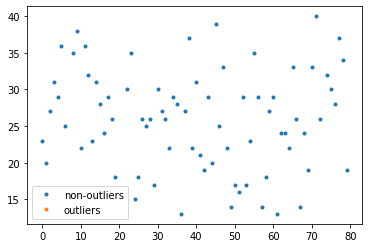

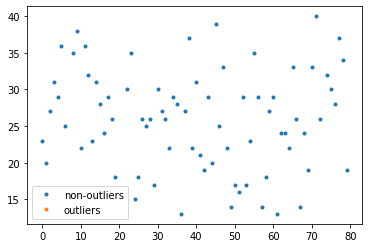

26.0 20.266128342428956 5.733871657571044 46.266128342428956


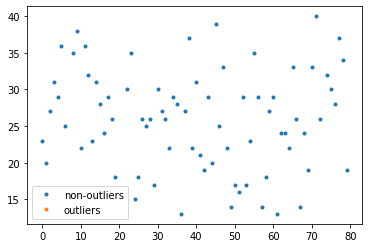

76 , 76


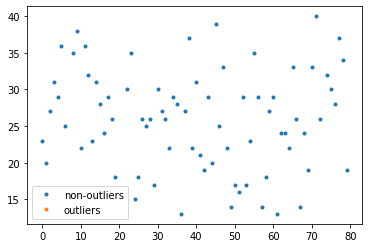

76 , 76


#### RMQ_locomotion

4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387


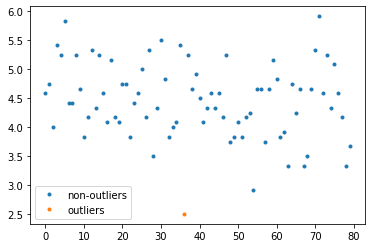

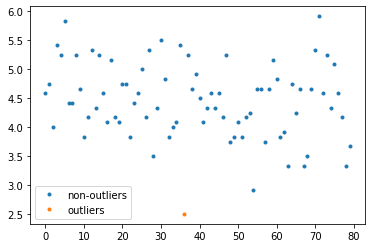

4.458333333333335 1.6898243675770521 2.7685089657562827 6.148157700910387


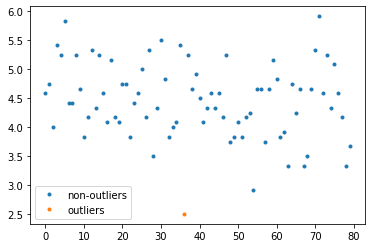

80 , 79
4.5 1.6895886466474699 2.81041135335253 6.18958864664747


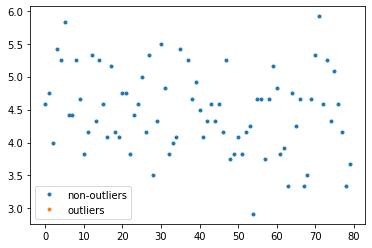

79 , 79


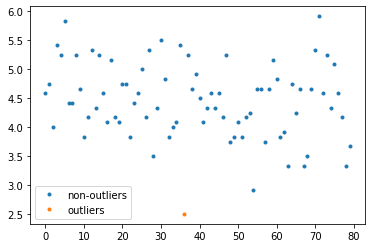

80 , 79


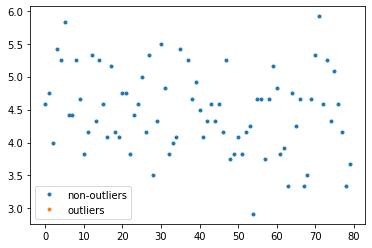

79 , 79


#### ses_aggregate

-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254


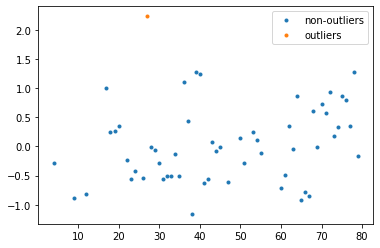

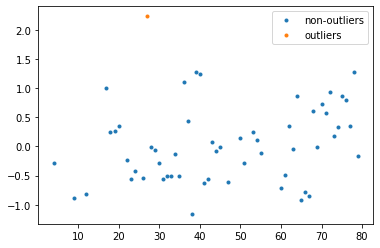

-0.029198517658926098 2.0272800228666514 -2.0564785405255774 1.9980815052077254


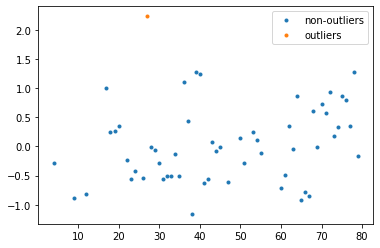

56 , 55
-0.04359384351429142 1.9200402150485443 -1.9636340585628358 1.8764463715342528


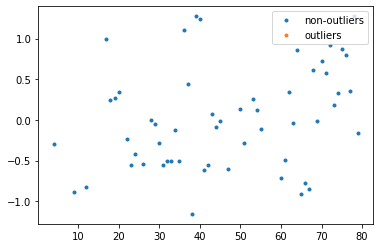

55 , 55


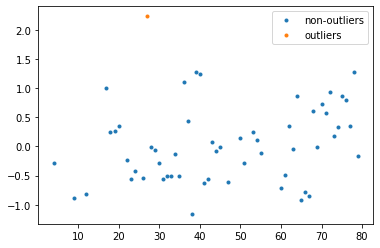

56 , 55


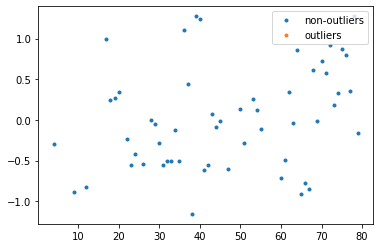

55 , 55


#### PLAN_cognitive_strategies

3.7 2.7021504456571925 0.9978495543428076 6.402150445657193


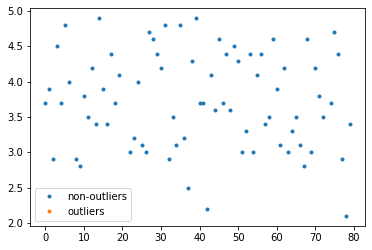

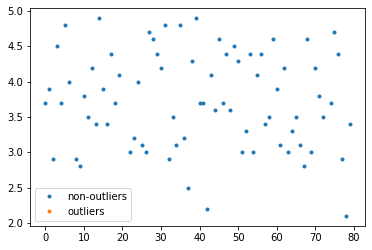

3.7 2.7021504456571925 0.9978495543428076 6.402150445657193


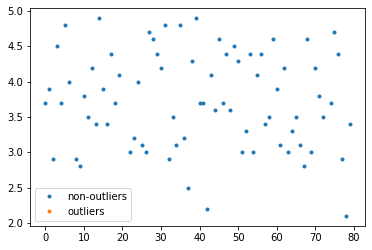

76 , 76


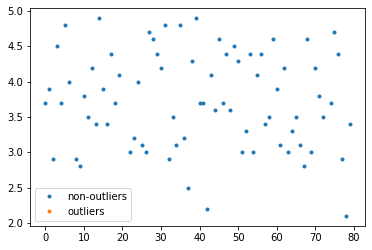

76 , 76


#### SST_SSRT

312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057


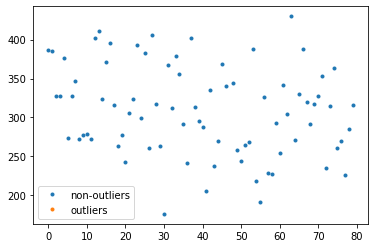

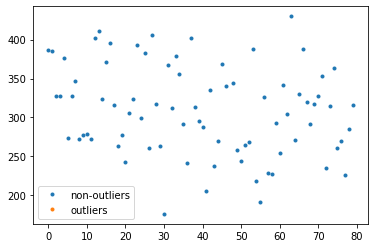

312.9325410023739 182.14878318668306 130.78375781569085 495.081324189057


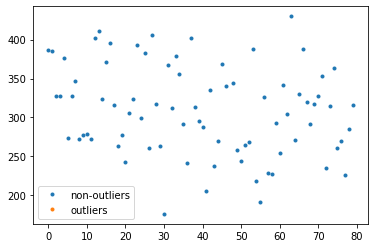

79 , 79


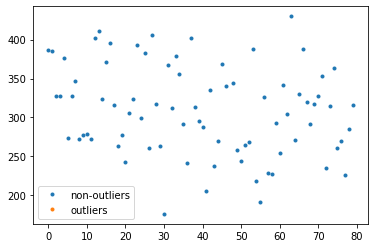

79 , 79


#### BIS_11

63.0 28.16373945961754 34.83626054038246 91.16373945961755


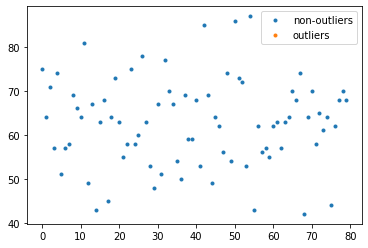

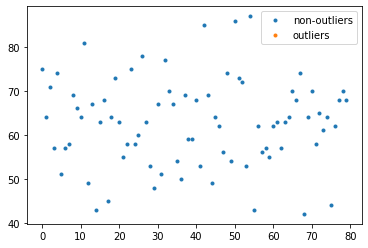

63.0 28.16373945961754 34.83626054038246 91.16373945961755


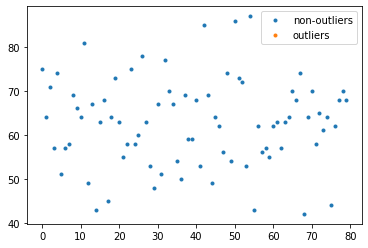

80 , 80


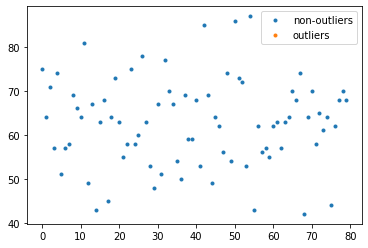

80 , 80


#### BSCS

3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118


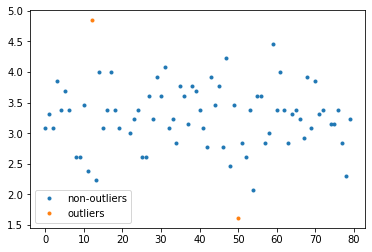

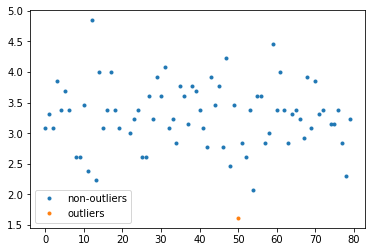

3.30769230769231 1.4723255633388697 1.8353667443534405 4.78001787103118


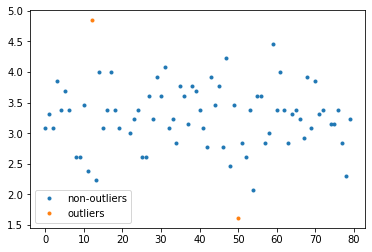

76 , 74
3.30769230769231 1.3852831642481158 1.9224091434441943 4.692975471940426


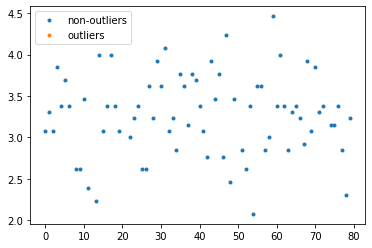

74 , 74


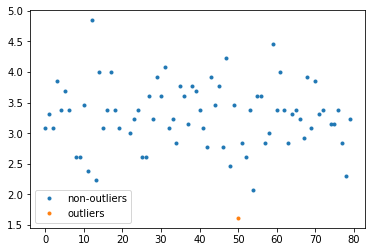

76 , 75


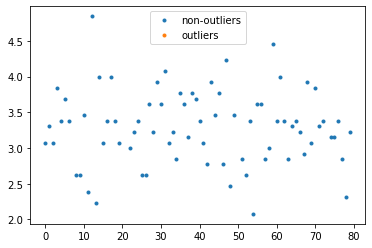

75 , 75


#### TESQ_E_suppression

8.0 9.005773331715183 -1.005773331715183 17.005773331715183


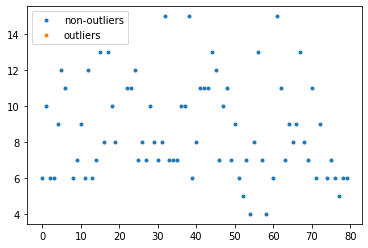

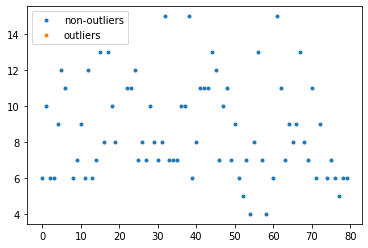

8.0 9.005773331715183 -1.005773331715183 17.005773331715183


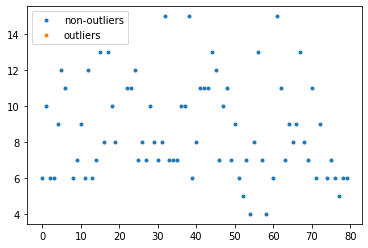

75 , 75


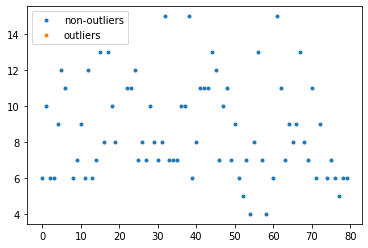

75 , 75


#### TESQ_E_avoidance_of_temptations

8.0 9.005773331715183 -1.005773331715183 17.005773331715183


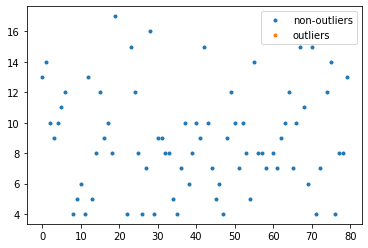

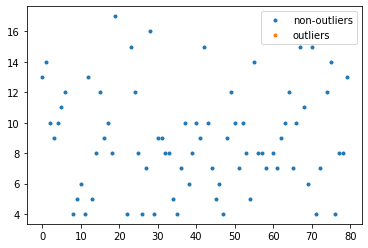

8.0 9.005773331715183 -1.005773331715183 17.005773331715183


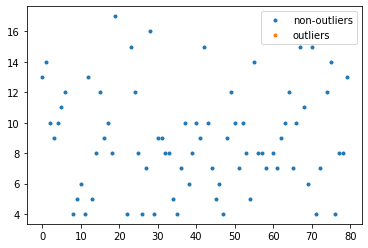

75 , 75


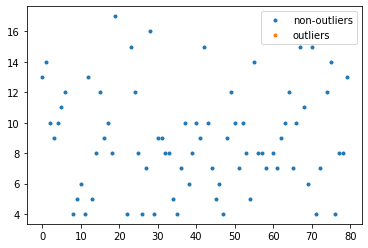

75 , 75


#### TESQ_E_goal_deliberation

9.0 6.754329998786387 2.245670001213613 15.754329998786387


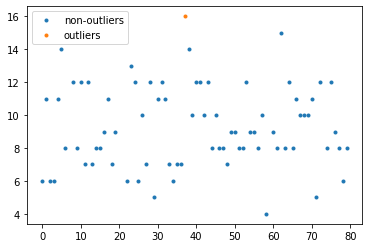

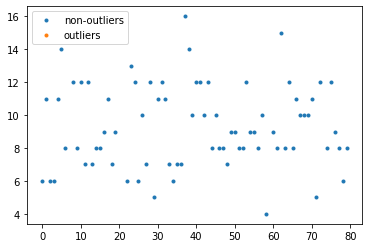

9.0 6.754329998786387 2.245670001213613 15.754329998786387


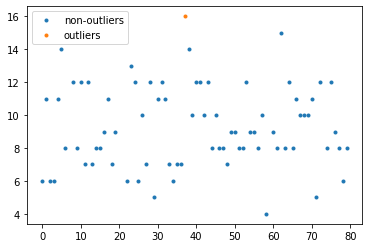

75 , 74
9.0 6.753255425709515 2.246744574290485 15.753255425709515


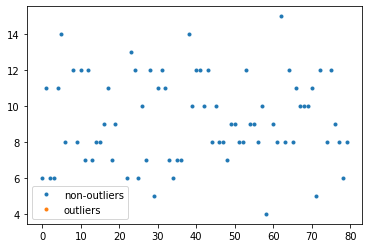

74 , 74


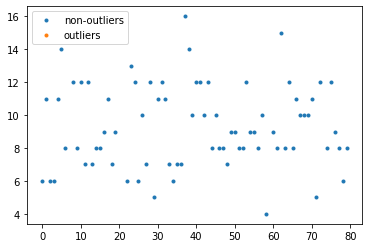

75 , 75


#### TESQ_E_controlling_temptations

9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183


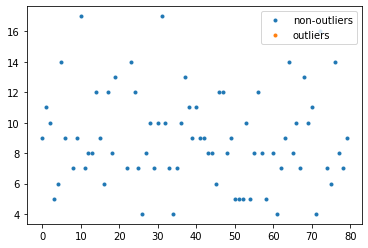

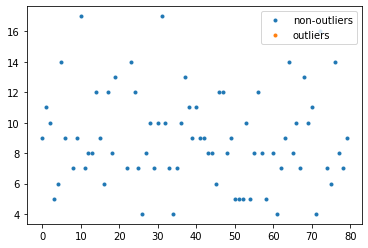

9.0 9.005773331715183 -0.0057733317151829056 18.005773331715183


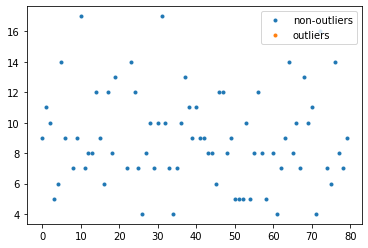

75 , 75


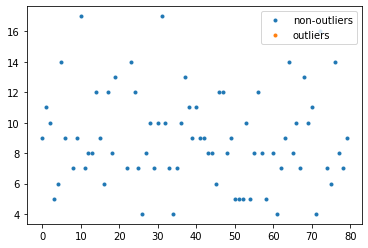

75 , 75


#### TESQ_E_distraction

7.0 9.005773331715183 -2.005773331715183 16.005773331715183


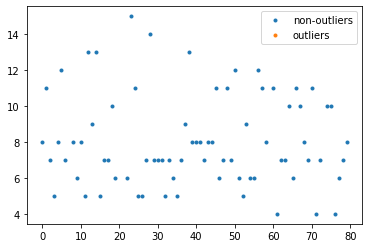

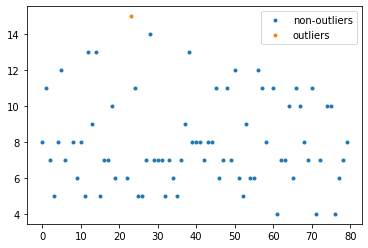

7.0 9.005773331715183 -2.005773331715183 16.005773331715183


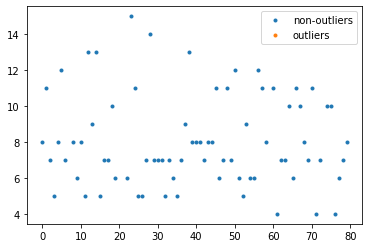

75 , 75


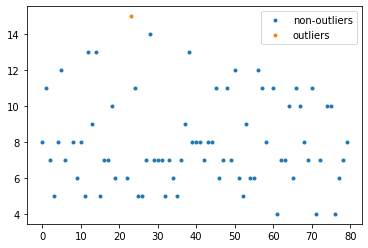

75 , 74


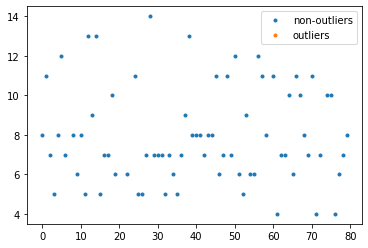

74 , 74


#### TESQ_E_goal_and_rule_setting

9.0 7.880051665250785 1.119948334749215 16.880051665250786


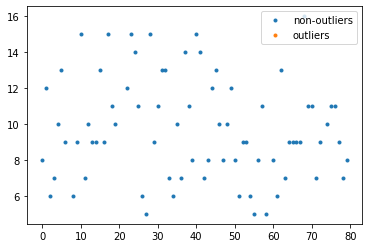

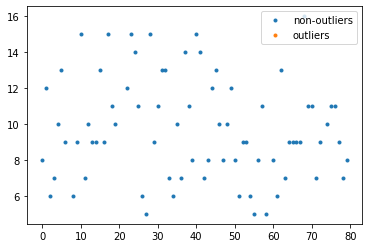

9.0 7.880051665250785 1.119948334749215 16.880051665250786


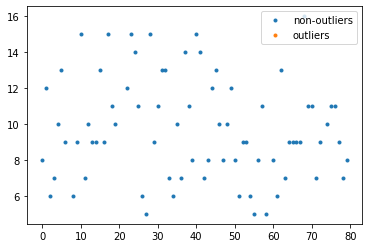

75 , 75


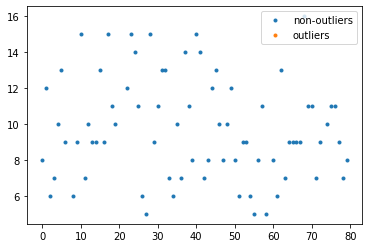

75 , 75


#### EDM

2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491


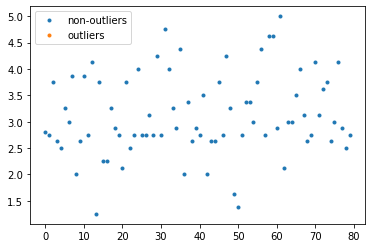

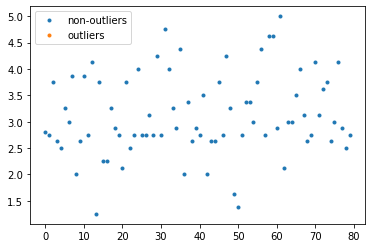

2.9375 2.3939178540674906 0.5435821459325094 5.331417854067491


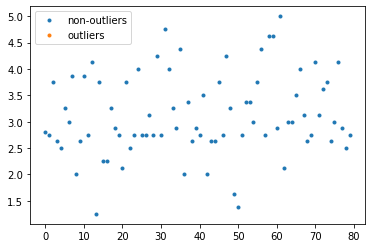

80 , 80


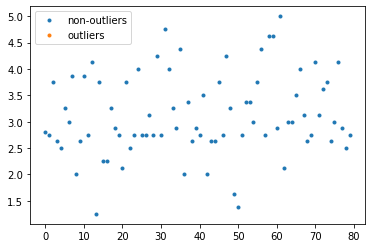

80 , 80


#### RS

18.0 10.13753187988482 7.86246812011518 28.13753187988482


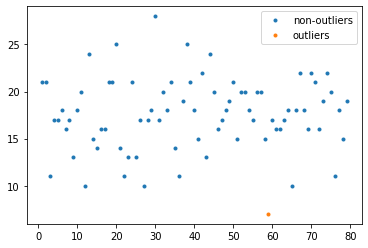

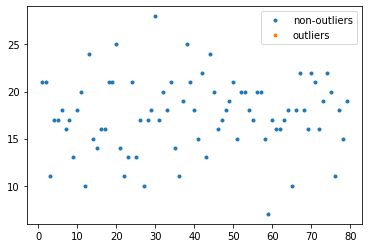

18.0 10.13753187988482 7.86246812011518 28.13753187988482


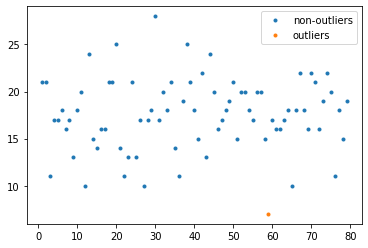

79 , 78
18.0 9.009849835836068 8.990150164163932 27.009849835836068


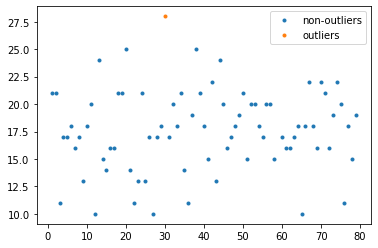

78 , 77
18.0 9.008526516622485 8.991473483377515 27.008526516622485


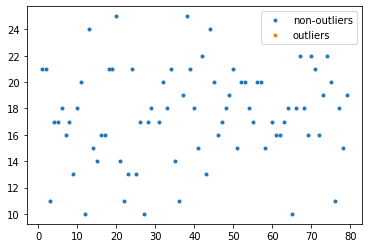

77 , 77


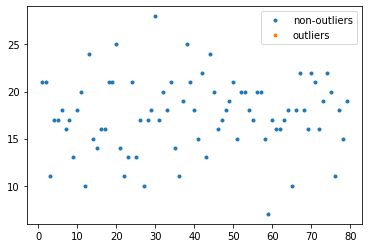

79 , 79


#### TRSQ

64.0 29.268763328074343 34.73123667192566 93.26876332807434


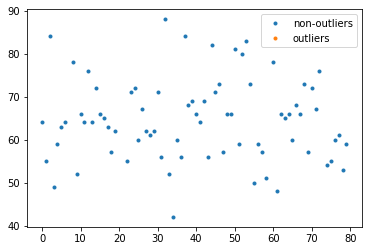

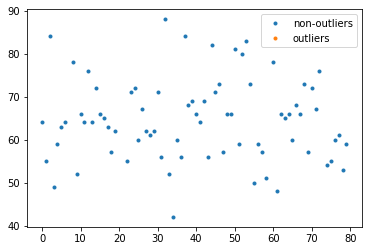

64.0 29.268763328074343 34.73123667192566 93.26876332807434


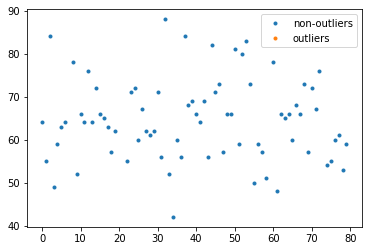

75 , 75


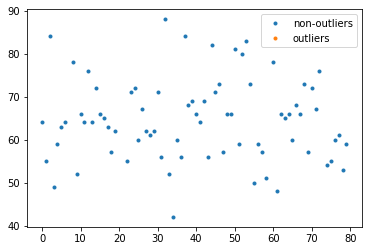

75 , 75


#### ROC_Crave_Regulate_Minus_Look

-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045


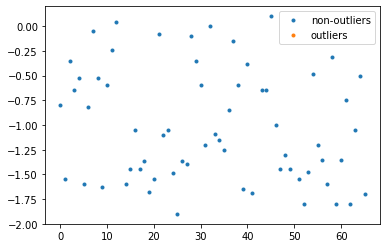

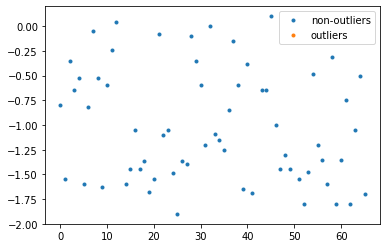

-1.1 2.0638697020107046 -3.1638697020107047 0.9638697020107045


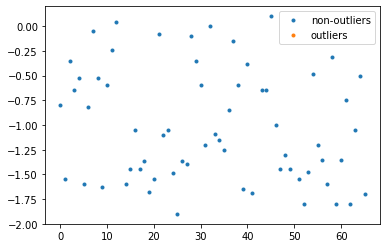

63 , 63


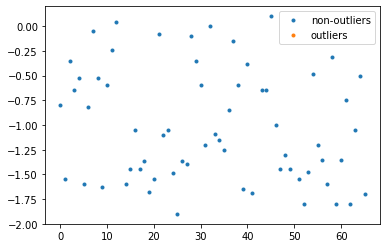

63 , 63


#### SRHI_unhealthy

46.5 29.273296494619604 17.226703505380396 75.7732964946196


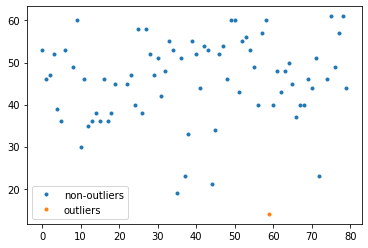

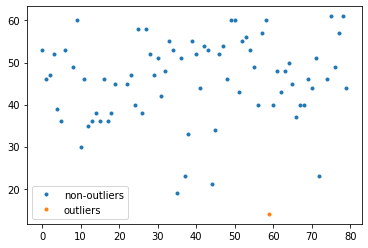

46.5 29.273296494619604 17.226703505380396 75.7732964946196


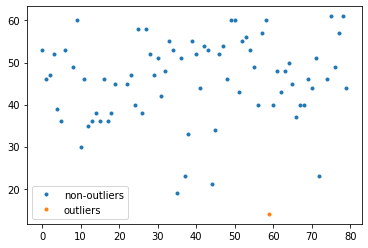

76 , 75
47.0 29.268763328074343 17.731236671925657 76.26876332807434


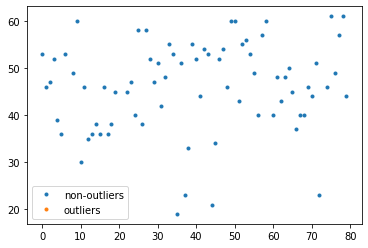

75 , 75


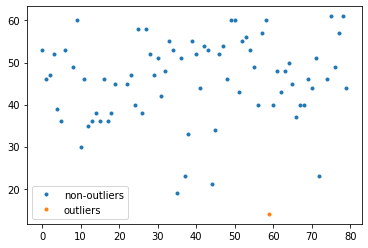

76 , 75


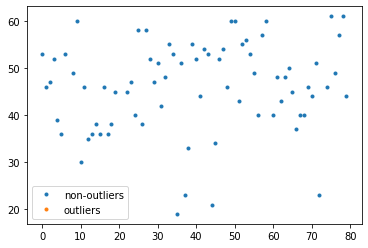

75 , 75


#### cancer_promoting_minus_preventing_FFQ

-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677


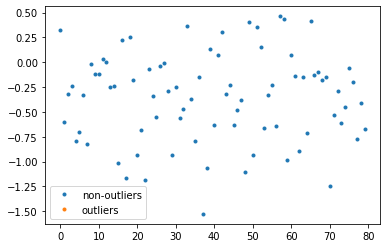

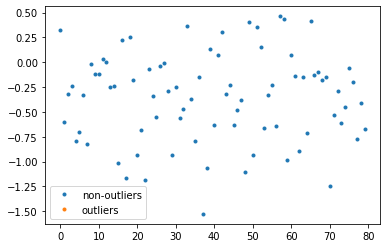

-0.3057692307692349 1.3648581430430025 -1.6706273738122372 1.0590889122737677


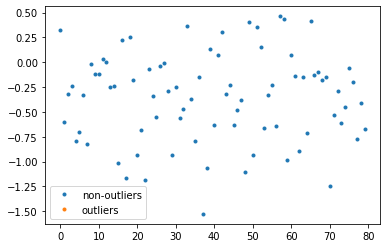

80 , 80


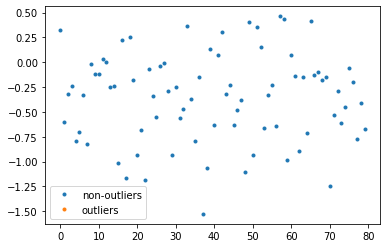

80 , 80


#### bf_1

40.15 23.178488718680573 16.971511281319426 63.328488718680575


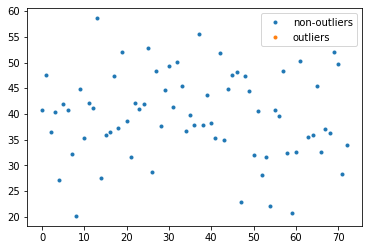

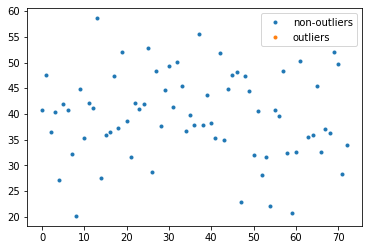

40.15 23.178488718680573 16.971511281319426 63.328488718680575


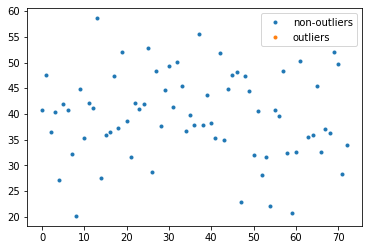

72 , 72


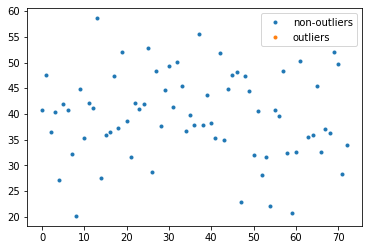

72 , 72


In [31]:
ind_div_combined_3sd = remove_selected_outliers_tesq_study(
    ind_div_combined,
    show_plot=True)

### discriminability_overfit_accuracy

#### BFI_extraversion

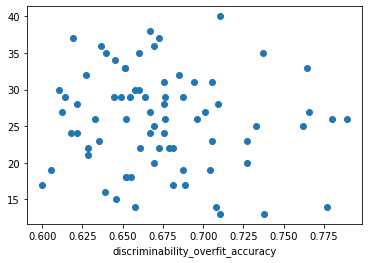

#### RMQ_locomotion

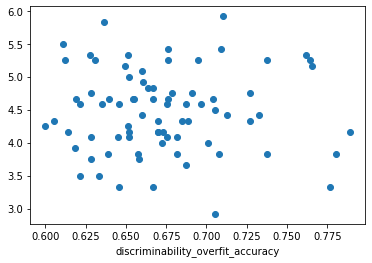

#### ses_aggregate

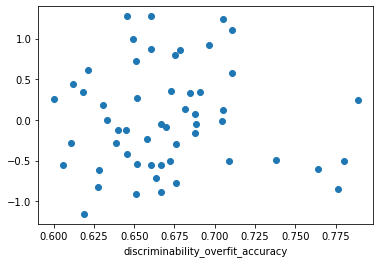

#### PLAN_cognitive_strategies

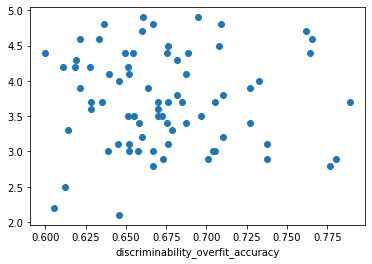

#### SST_SSRT

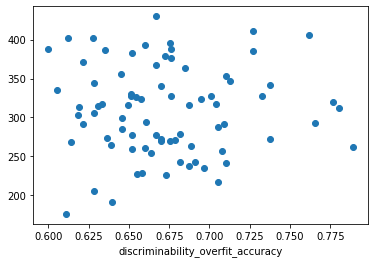

#### BIS_11

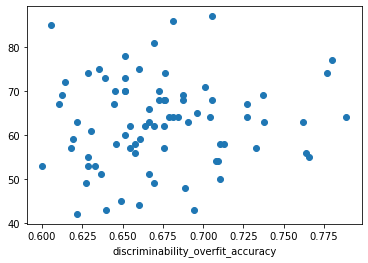

#### BSCS

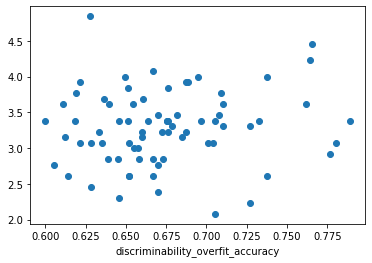

#### TESQ_E_suppression

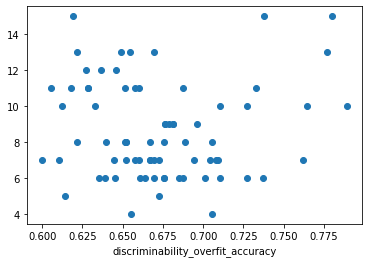

#### TESQ_E_avoidance_of_temptations

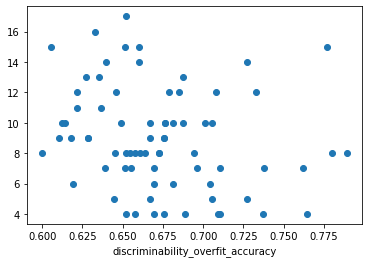

#### TESQ_E_goal_deliberation

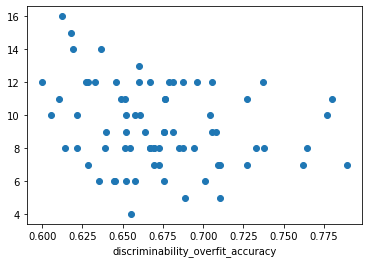

#### TESQ_E_controlling_temptations

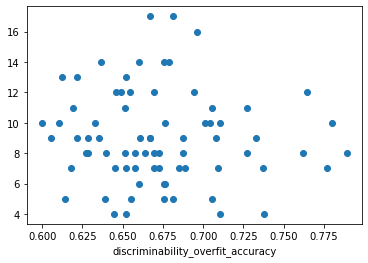

#### TESQ_E_distraction

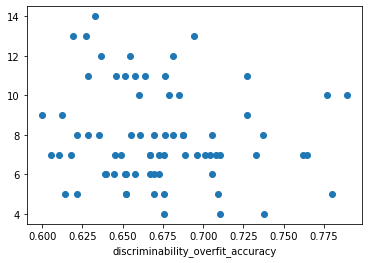

#### TESQ_E_goal_and_rule_setting

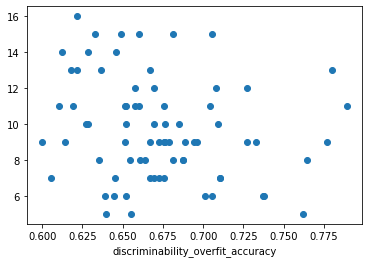

#### EDM

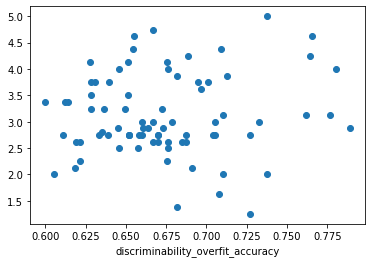

#### RS

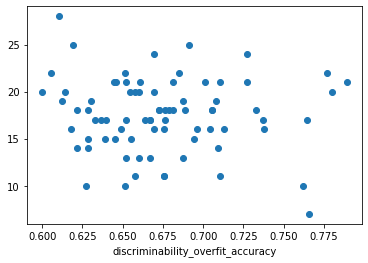

#### TRSQ

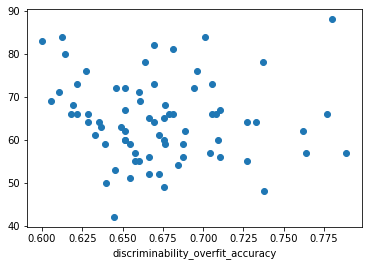

#### ROC_Crave_Regulate_Minus_Look

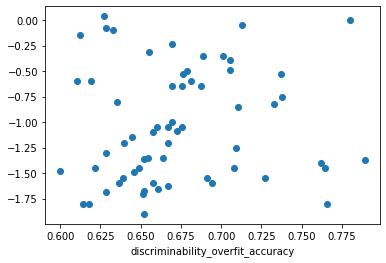

#### SRHI_unhealthy

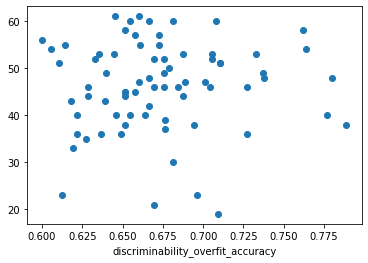

### discriminability_mean_cv_scores

#### BFI_extraversion

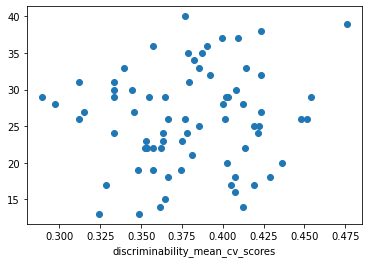

#### RMQ_locomotion

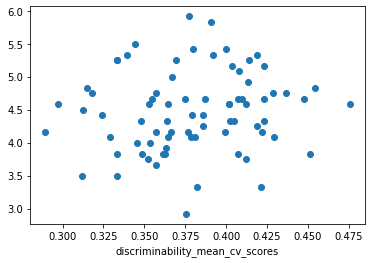

#### ses_aggregate

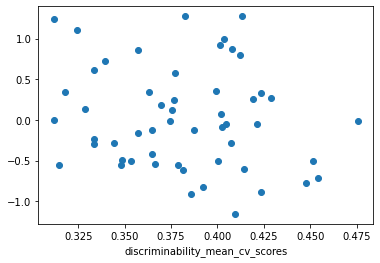

#### PLAN_cognitive_strategies

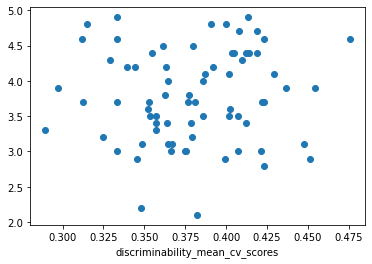

#### SST_SSRT

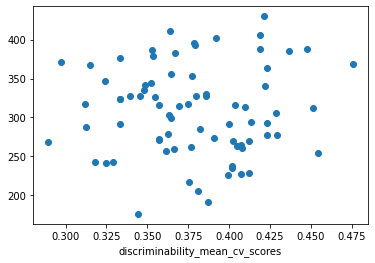

#### BIS_11

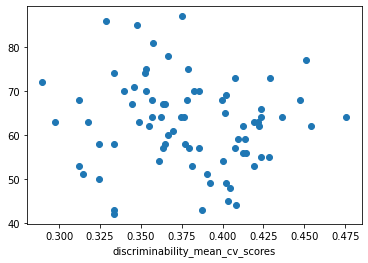

#### BSCS

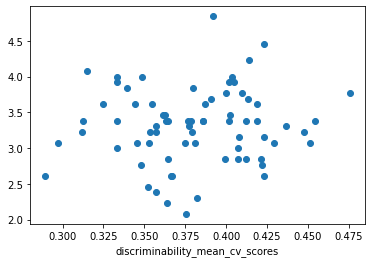

#### TESQ_E_suppression

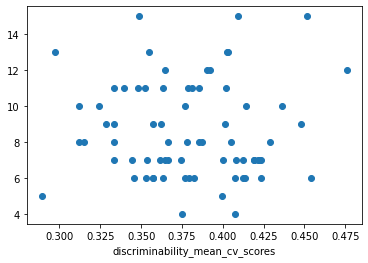

#### TESQ_E_avoidance_of_temptations

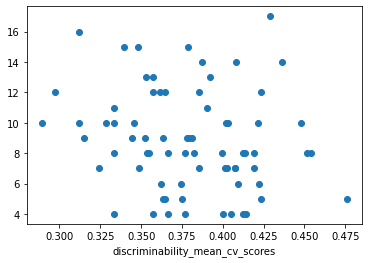

#### TESQ_E_goal_deliberation

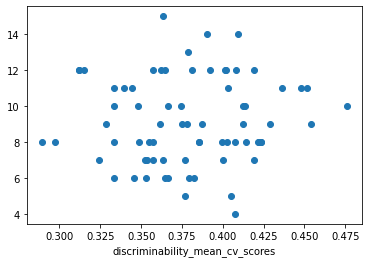

#### TESQ_E_controlling_temptations

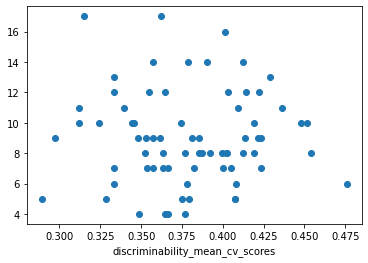

#### TESQ_E_distraction

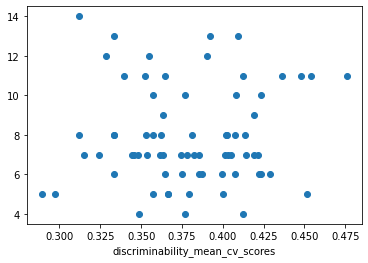

#### TESQ_E_goal_and_rule_setting

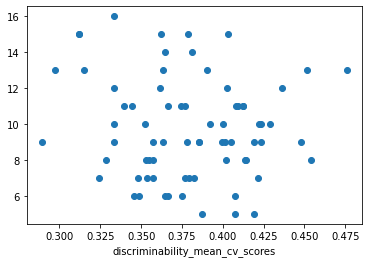

#### EDM

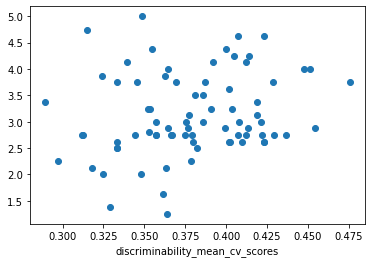

#### RS

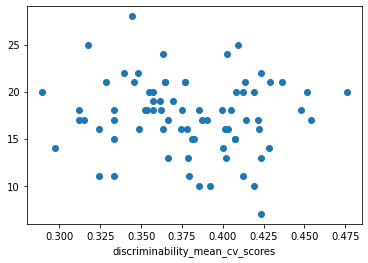

#### TRSQ

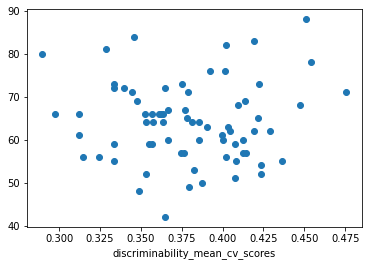

#### ROC_Crave_Regulate_Minus_Look

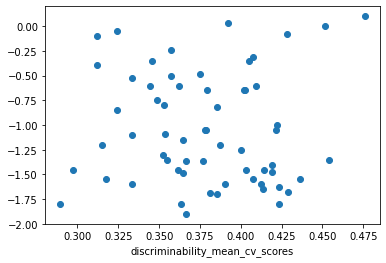

#### SRHI_unhealthy

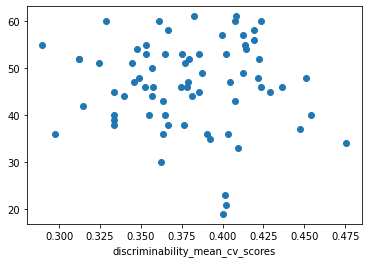

In [37]:
display_discriminability_correlations(ind_div_combined_3sd)

## pfc only

In [7]:
dataset_name = 'conditions'


brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_84subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_betaseries_58subs_correct_cond.pkl'
#brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_43subs_correct_cond.pkl'

# def decoderConstructor(*args, **kwargs):
#     return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))

In [8]:
pfc_mask = create_mask_from_images(get_pfc_image_filepaths(ml_data_folderpath + "/"),threshold=10)
relevant_mask = pfc_mask


(8, 238955)
2


In [9]:
all_subjects = load_and_preprocess(
    brain_data_filepath,
    train_test_markers_filepath,
    subjs_to_use = None,
    response_transform_func = trialtype_resp_trans_func,
    clean=None)

all_subjects['groups']

subj_list = np.unique(all_subjects['groups'])

del all_subjects
gc.collect()

checked for intersection and no intersection between the brain data and the subjects was found.
there were 58 subjects overlapping between the subjects marked for train data and the training dump file itself.
test_train_set: 9549
pkl_file: 168
brain_data_filepath: 152
train_test_markers_filepath: 141
response_transform_func: 136
sys: 72
Brain_Data_allsubs: 48
clean: 16
subjs_to_use: 16


/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/apply_loocv_and_save.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None


9037
9037


0

In [10]:
summary_results = get_all_subjs_discriminability_masked(
    subj_list, "v_1_pfc",ml_data_folderpath=ml_data_folderpath,
    subject_discrim_args = 
    {'train_test_markers_filepath':train_test_markers_filepath, 
     'brain_data_filepath':brain_data_filepath, 
     'resp_trans_func': trialtype_resp_trans_func,
     'mask':pfc_mask})

DEV005

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV005.pkl


pre-loaded.

DEV006

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV006.pkl


pre-loaded.

DEV009

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV009.pkl


pre-loaded.

DEV010

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV010.pkl


pre-loaded.

DEV011

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV011.pkl


pre-loaded.

DEV012

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV012.pkl


pre-loaded.

DEV013

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV013.pkl


pre-loaded.

DEV014

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV014.pkl


pre-loaded.

DEV015

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV015.pkl


pre-loaded.

DEV016

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV016.pkl


pre-loaded.

DEV017

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV017.pkl


pre-loaded.

DEV018

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV018.pkl


pre-loaded.

DEV019

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV019.pkl


pre-loaded.

DEV020

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV020.pkl


pre-loaded.

DEV021

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV021.pkl


pre-loaded.

DEV022

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV022.pkl


pre-loaded.

DEV023

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV023.pkl


pre-loaded.

DEV024

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV024.pkl


pre-loaded.

DEV025

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV025.pkl


pre-loaded.

DEV026

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV026.pkl


pre-loaded.

DEV027

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV027.pkl


pre-loaded.

DEV028

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV028.pkl


pre-loaded.

DEV029

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV029.pkl


pre-loaded.

DEV030

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV030.pkl


pre-loaded.

DEV034

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV034.pkl


pre-loaded.

DEV035

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV035.pkl


pre-loaded.

DEV036

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV036.pkl


pre-loaded.

DEV039

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV039.pkl


pre-loaded.

DEV040

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV040.pkl


pre-loaded.

DEV041

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV041.pkl


pre-loaded.

DEV042

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV042.pkl


pre-loaded.

DEV043

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV043.pkl


pre-loaded.

DEV046

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV046.pkl


pre-loaded.

DEV047

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV047.pkl


pre-loaded.

DEV048

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV048.pkl


pre-loaded.

DEV049

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV049.pkl


pre-loaded.

DEV050

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV050.pkl


pre-loaded.

DEV051

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV051.pkl


pre-loaded.

DEV052

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV052.pkl


pre-loaded.

DEV053

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV053.pkl


pre-loaded.

DEV055

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV055.pkl


pre-loaded.

DEV056

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV056.pkl


pre-loaded.

DEV057

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV057.pkl


pre-loaded.

DEV058

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV058.pkl


pre-loaded.

DEV059

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV059.pkl


pre-loaded.

DEV060

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV060.pkl


pre-loaded.

DEV062

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV062.pkl


pre-loaded.

DEV064

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV064.pkl


pre-loaded.

DEV067

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV067.pkl


pre-loaded.

DEV068

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV068.pkl


pre-loaded.

DEV069

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV069.pkl


pre-loaded.

DEV071

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV071.pkl


pre-loaded.

DEV073

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV073.pkl


pre-loaded.

DEV074

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV074.pkl


pre-loaded.

DEV076

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV076.pkl


pre-loaded.

DEV077

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV077.pkl


pre-loaded.

DEV079

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV079.pkl


pre-loaded.

DEV083

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV083.pkl


pre-loaded.

DEV084

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV084.pkl


pre-loaded.

DEV085

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV085.pkl


pre-loaded.

DEV086

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV086.pkl


pre-loaded.

DEV087

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV087.pkl


pre-loaded.

DEV089

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV089.pkl


pre-loaded.

DEV097

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV097.pkl


pre-loaded.

DEV105

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV105.pkl


pre-loaded.

DEV107

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV107.pkl


pre-loaded.

DEV135

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV135.pkl


pre-loaded.

DEV141

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV141.pkl


pre-loaded.

DEV145

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV145.pkl


pre-loaded.

DEV157

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV157.pkl


pre-loaded.

DEV158

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV158.pkl


pre-loaded.

DEV159

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV159.pkl


pre-loaded.

DEV164

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV164.pkl


pre-loaded.

DEV169

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV169.pkl


pre-loaded.

DEV171

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV171.pkl


pre-loaded.

DEV173

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV173.pkl


pre-loaded.

DEV177

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV177.pkl


pre-loaded.

DEV186

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV186.pkl


pre-loaded.

DEV197

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV197.pkl


pre-loaded.

DEV206

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV206.pkl


pre-loaded.

DEV215

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV215.pkl


pre-loaded.

DEV216

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV216.pkl


pre-loaded.

DEV217

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV217.pkl


pre-loaded.

DEV218

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/discriminability_cache/v_1_pfc/dtt_results_DEV218.pkl


pre-loaded.